In [1]:
# Imports needed to run
import importlib
import matplotlib.pyplot as plt
import LearningCutsUtils
## needed if we change LearningCutsUtils and want to avoid reloading the kernel to see the effects
importlib.reload(LearningCutsUtils)
import numpy as np

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score

import torch
import torch.nn
import torch.optim
import torch.utils.data


from LearningCutsUtils import OneToOneLinear, EfficiencyScanNetwork
from LearningCutsUtils import loss_fn, effic_loss_fn, lossvars

# Using LCU functions; load_random_data & load_SUSY_data
import LearningCutsUtils.Utils as LCU

import time

In [2]:
def plotting_features(signal, background, branches, m):
    plotsacross=5 if (m==10) else 4
    
    fig = plt.figure(figsize=(20,2.5*(int(m/plotsacross)+1)))
    fig.tight_layout()
    nbins=50
    
    for b in range(m):
        ax=fig.add_subplot(int(m/plotsacross)+1,plotsacross,1+b)
        plt.subplots_adjust(hspace=0.5,wspace=0.5)
        plt.yscale('log')
        ax.hist(signal[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
        ax.hist(background[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
        ax.set_xlabel(f"{branches[b]}")
        ax.set_ylabel("Events/Bin")

In [3]:
def concatenating(xSig, ySig, xBack, yBack):
    return np.concatenate((xSig, xBack)), np.concatenate((ySig, yBack))

# Random Data Set

In [4]:
x_signal, y_signal, x_backgr, y_backgr, branchFeatures = LCU.load_random_data()

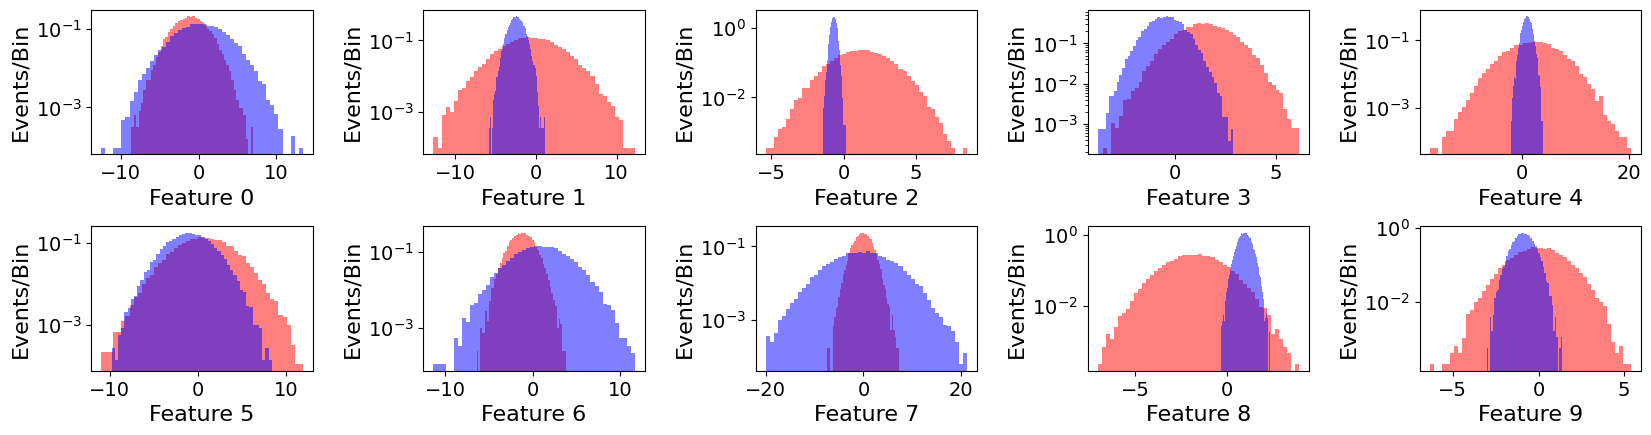

In [5]:
m = len(branchFeatures)
plotting_features(x_signal, x_backgr, branchFeatures, m)

In [6]:
x, y = concatenating(x_signal, y_signal, x_backgr, y_backgr)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [8]:
sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train)
x_test_scaled  = sc.transform(x_test)

In [9]:
x_train_tensor=torch.tensor(x_train_scaled,dtype=torch.float)
y_train_tensor=torch.tensor(y_train,dtype=torch.float)

x_test_tensor=torch.tensor(x_test_scaled,dtype=torch.float)
y_test_tensor=torch.tensor(y_test,dtype=torch.float)

In [10]:
gt=1.
lt=-1.
cuts_gt_lt = []
if m==10:
    cuts_gt_lt = [lt, gt, gt, gt, lt,
                  gt, lt, lt, lt, gt]
elif m==5:
    cuts_gt_lt = [lt, gt, gt, gt, gt]

In [11]:
targeteffics=[0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

# some hyperparameters
learning_rate=0.5
batch_size=int(len(y_train)/1.) # only one batch
epochs=25

# how we scale the inputs to the activation function.
# larger values improve the matching of the signal efficiency
# calculated in the loss function and the efficiency that we
# see when applying the cuts.
activation_input_scale_factor=15

# parameters for the loss functions
alpha    = 1e1   # scaling factor to tune how important hitting the target signal efficiency is
beta     = 1e-1  # scaling factor to tune how important background rejection is
gamma    = 1e-5  # scaling factor for how aggressively to push the cuts to zero
delta    = 1e-6  # scaling factor for how much to use BCE loss to optimize
epsilon  = 1e0   # how much to penalize deviations.  as the exponent goes down, this should go down too.

In [12]:
torch.manual_seed(123)

net = EfficiencyScanNetwork(m,targeteffics,cuts_gt_lt,activation_input_scale_factor) # will take m inputs, return m*n_eff outputs
torch.save(net.state_dict(), 'models/net_learningbiases_effictarget_untrained.pth')

optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.1)

In [13]:
losses = []
losses_test = []

net.load_state_dict(torch.load('models/net_learningbiases_effictarget_untrained.pth',weights_only=True))

xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=batch_size, shuffle=True)

debug=False

for epoch in range(epochs):
    net.train()
    start_time = time.time()
    for x_batch, y_batch in loader:
        y_pred = net(x_batch)
        optimizer.zero_grad()
        loss = effic_loss_fn(y_pred, y_batch, m, net, alpha, beta, gamma, delta, epsilon,debug=debug)
        loss.totalloss().backward()
        optimizer.step()
    losses.append(loss)
    net.eval() # configure the model for evaluation (testing)
    y_pred = net(x_test_tensor)
    test_loss = effic_loss_fn(y_pred, y_test_tensor, m, net, alpha, beta, gamma, delta, epsilon)        
    losses_test.append(test_loss)
    end_time=time.time()
    elapsed_time = end_time - start_time
    print(f"Completed epoch {epoch:2d} in {elapsed_time:4.1f}s, Train loss={loss.totalloss().data:4.1e}, Test loss={test_loss.totalloss().data:4.1e}")

torch.save(net.state_dict(), 'models/net_learningbiases_effictarget_trained.pth')

Completed epoch  0 in  0.8s, Train loss=2.7e+01, Test loss=2.7e+01
Completed epoch  1 in  0.8s, Train loss=2.7e+01, Test loss=2.6e+01
Completed epoch  2 in  0.5s, Train loss=2.6e+01, Test loss=2.4e+01
Completed epoch  3 in  0.5s, Train loss=2.4e+01, Test loss=2.0e+01
Completed epoch  4 in  0.5s, Train loss=2.0e+01, Test loss=1.4e+01
Completed epoch  5 in  0.6s, Train loss=1.4e+01, Test loss=7.9e+00
Completed epoch  6 in  0.6s, Train loss=8.1e+00, Test loss=4.4e+00
Completed epoch  7 in  0.5s, Train loss=4.5e+00, Test loss=2.5e+00
Completed epoch  8 in  0.6s, Train loss=2.6e+00, Test loss=1.6e+00
Completed epoch  9 in  2.0s, Train loss=1.6e+00, Test loss=9.9e-01
Completed epoch 10 in  0.5s, Train loss=1.0e+00, Test loss=6.7e-01
Completed epoch 11 in  0.5s, Train loss=7.0e-01, Test loss=4.8e-01
Completed epoch 12 in  0.5s, Train loss=5.0e-01, Test loss=3.6e-01
Completed epoch 13 in  0.5s, Train loss=3.8e-01, Test loss=2.8e-01
Completed epoch 14 in  0.5s, Train loss=3.0e-01, Test loss=2.3

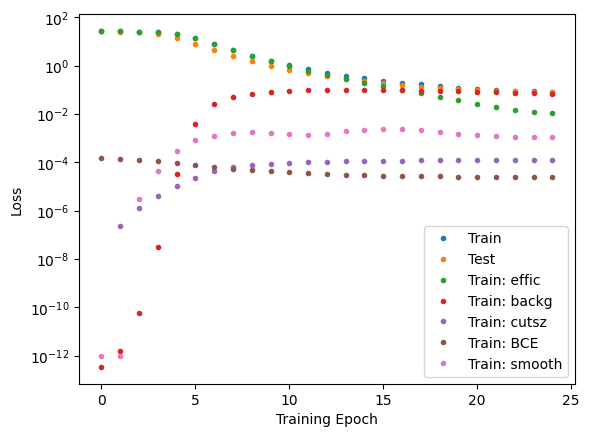

In [14]:
LCU.plotlosses(losses,losses_test)

In [15]:
for n in range(len(targeteffics)):
    print(f"Target efficiency: {targeteffics[n]*100}%")
    LCU.check_effic(x_test_tensor,y_test,net.nets[n],True)

    # check that after reloading the weights we still get the same performance after pretraining
    net.nets[n].eval() # configure the model for evaluation (testing)
    y_pred = net.nets[n](x_test_tensor)
    test_loss = loss_fn(y_pred, y_test_tensor, m, net.nets[n], targeteffics[n], alpha, beta, gamma, delta, True)
    print("------------")

Target efficiency: 20.0%
Signal     efficiency with net outputs: 20.6%
Background efficiency with net outputs:  0.00000%
Inspecting efficiency loss: alpha=10.0, target=0.200, subnet_effic=0.2002, subnet_backg=0.0003, efficloss=6.154e-07, backgloss=2.635e-05
------------
Target efficiency: 30.0%
Signal     efficiency with net outputs: 31.0%
Background efficiency with net outputs:  0.55193%
Inspecting efficiency loss: alpha=10.0, target=0.300, subnet_effic=0.3027, subnet_backg=0.0056, efficloss=7.203e-05, backgloss=5.637e-04
------------
Target efficiency: 40.0%
Signal     efficiency with net outputs: 40.8%
Background efficiency with net outputs:  1.65580%
Inspecting efficiency loss: alpha=10.0, target=0.400, subnet_effic=0.4019, subnet_backg=0.0193, efficloss=3.524e-05, backgloss=1.928e-03
------------
Target efficiency: 50.0%
Signal     efficiency with net outputs: 50.5%
Background efficiency with net outputs:  2.70948%
Inspecting efficiency loss: alpha=10.0, target=0.500, subnet_effic

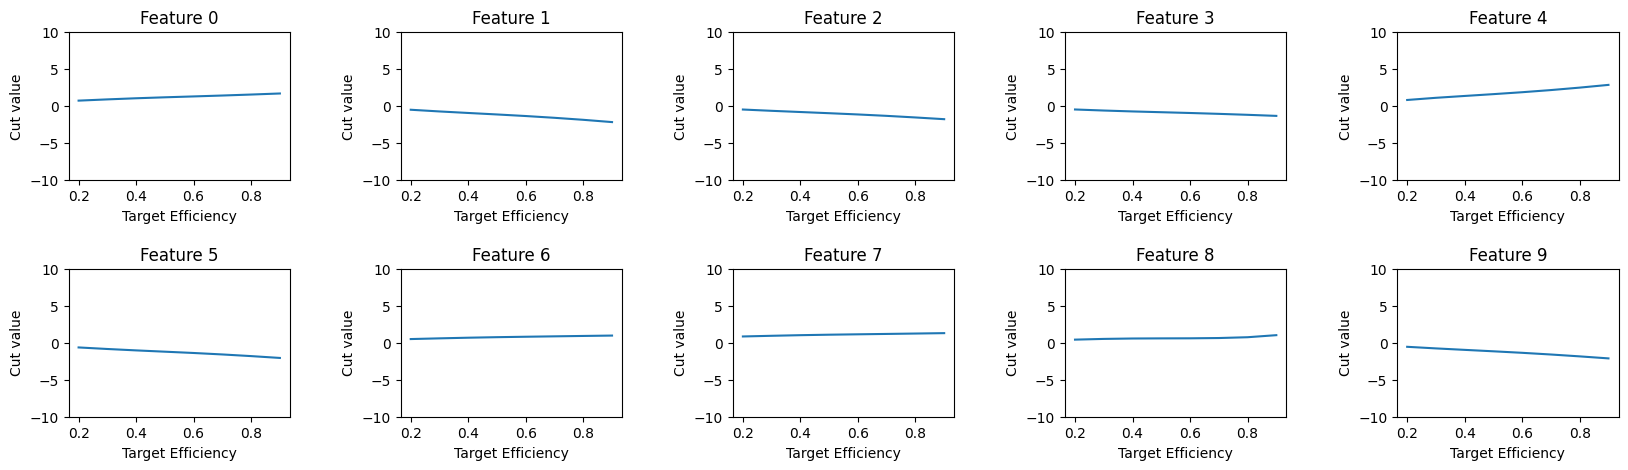

In [16]:
# Distributions of cuts
LCU.plotgenericcuts(net)

Target efficiency: 20.0%


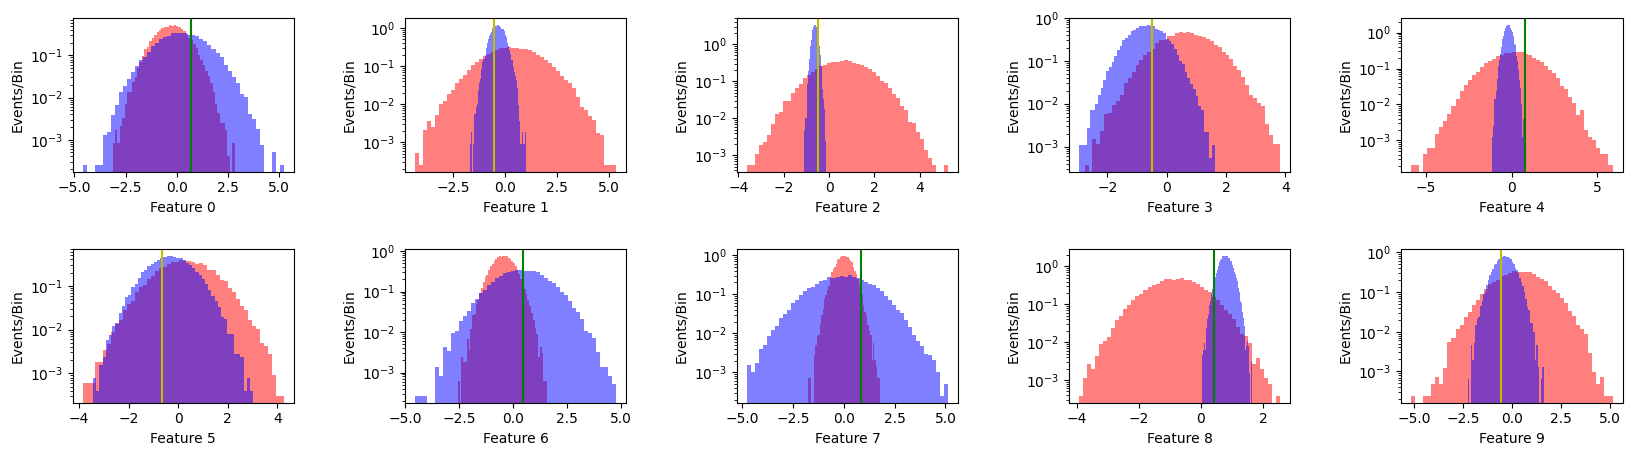

Target efficiency: 30.0%


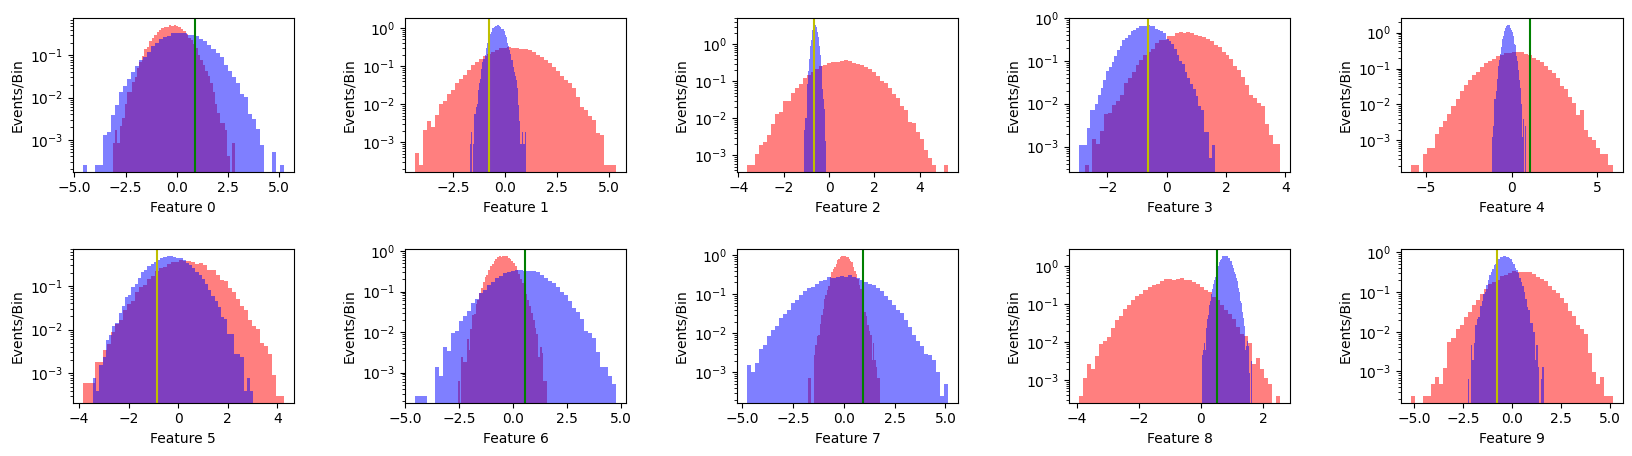

Target efficiency: 40.0%


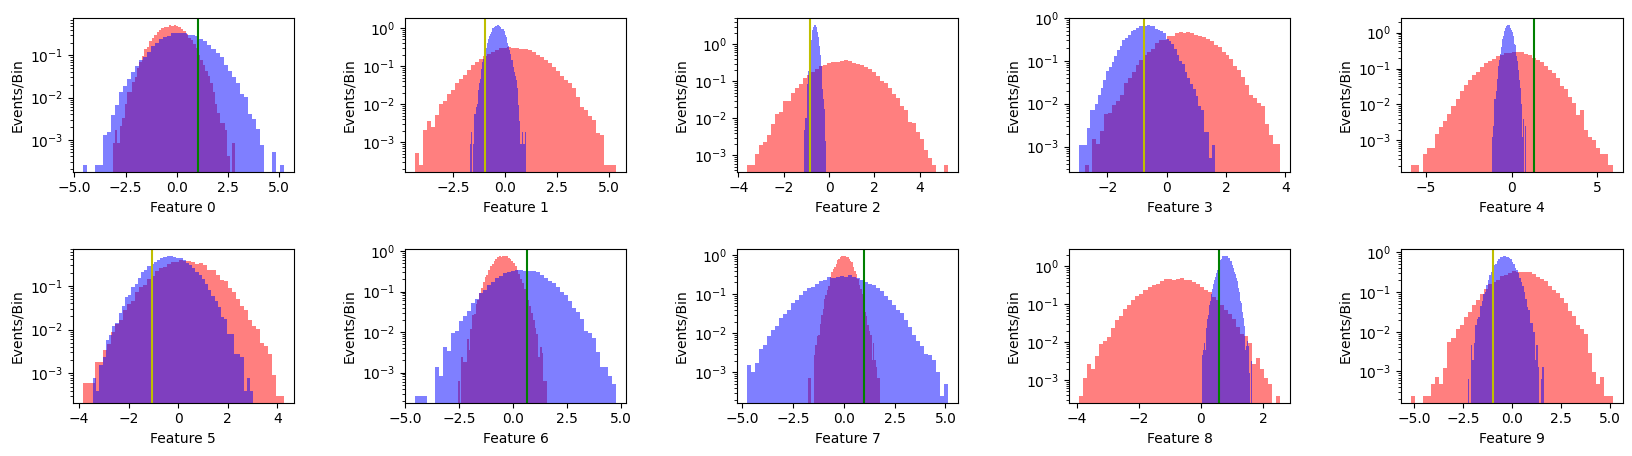

Target efficiency: 50.0%


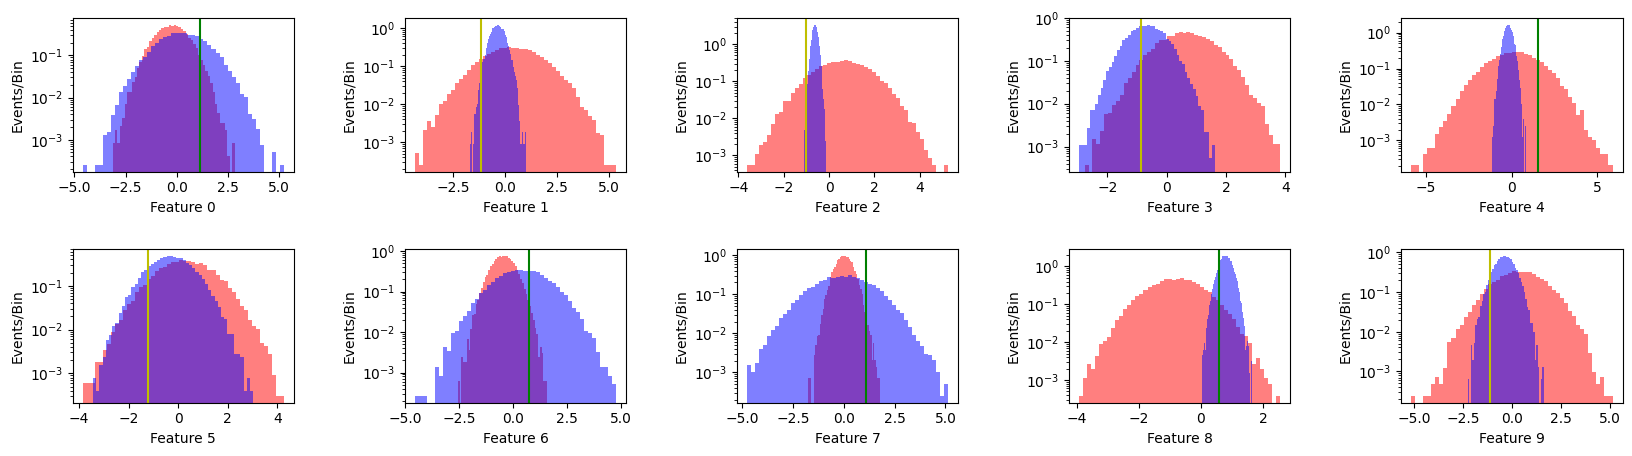

Target efficiency: 60.0%


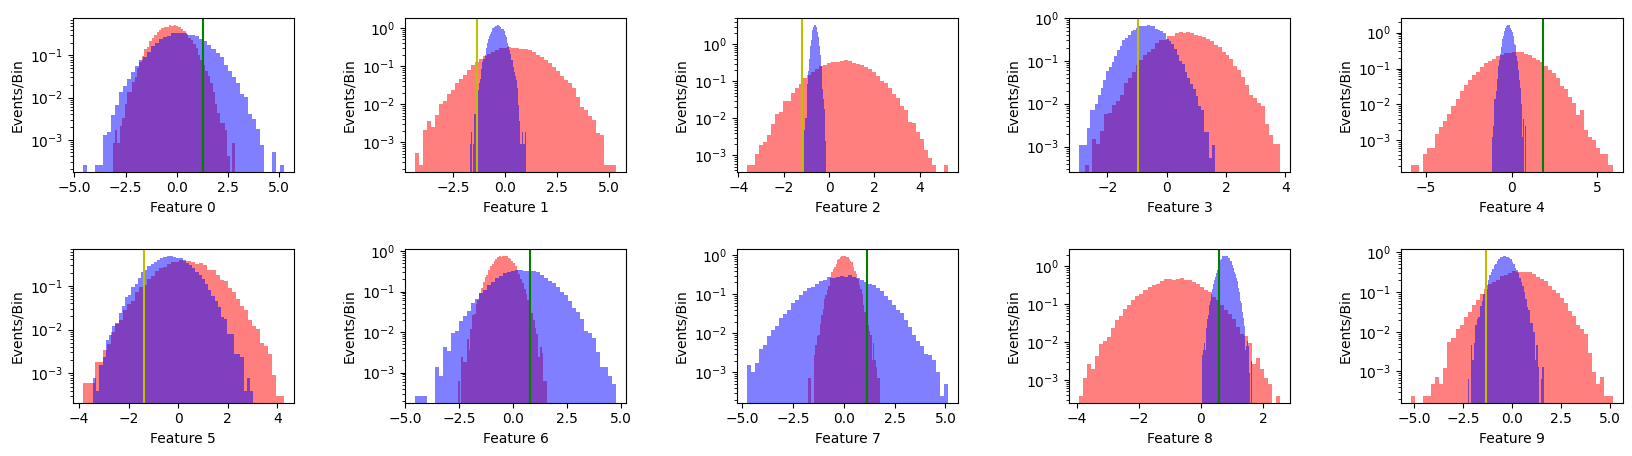

Target efficiency: 70.0%


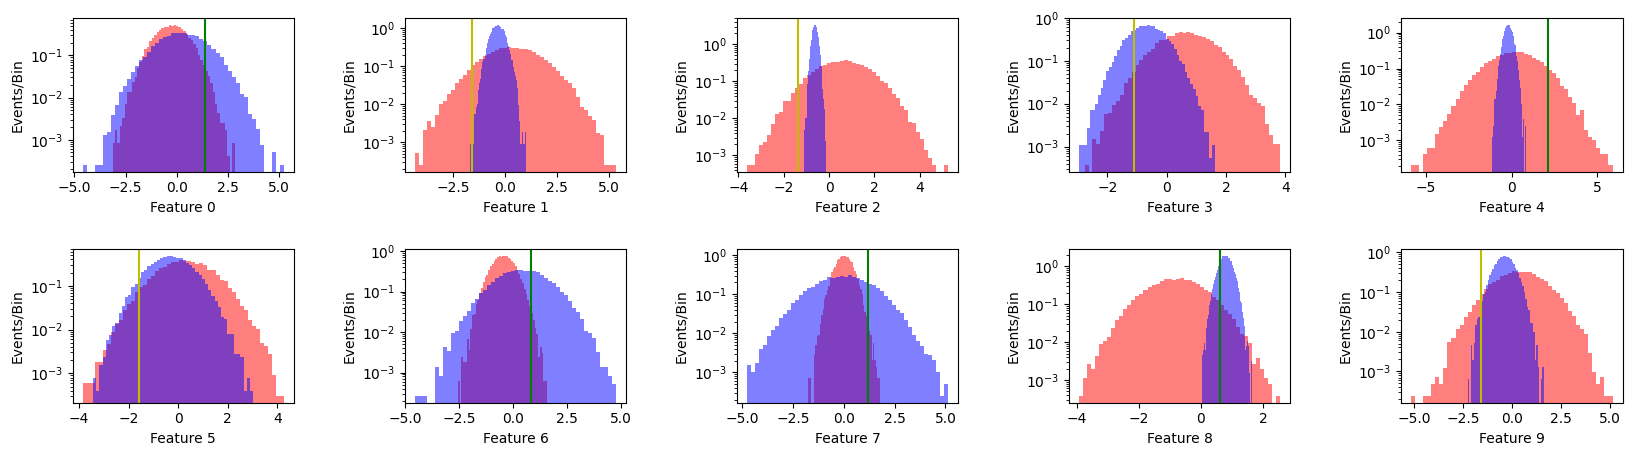

Target efficiency: 80.0%


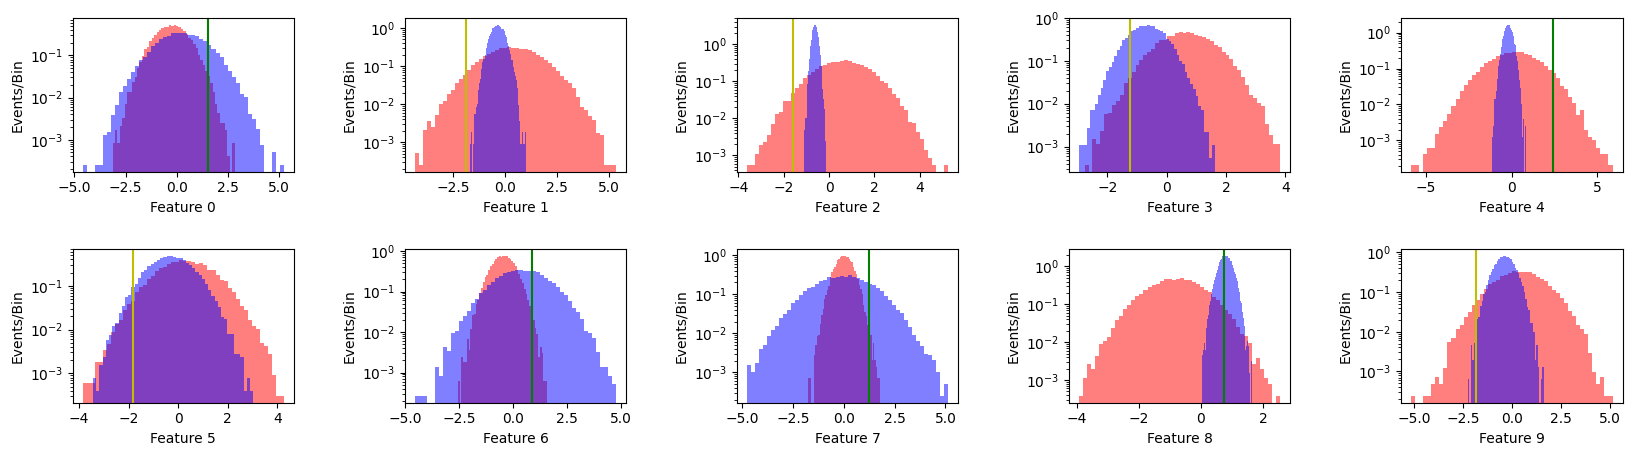

Target efficiency: 90.0%


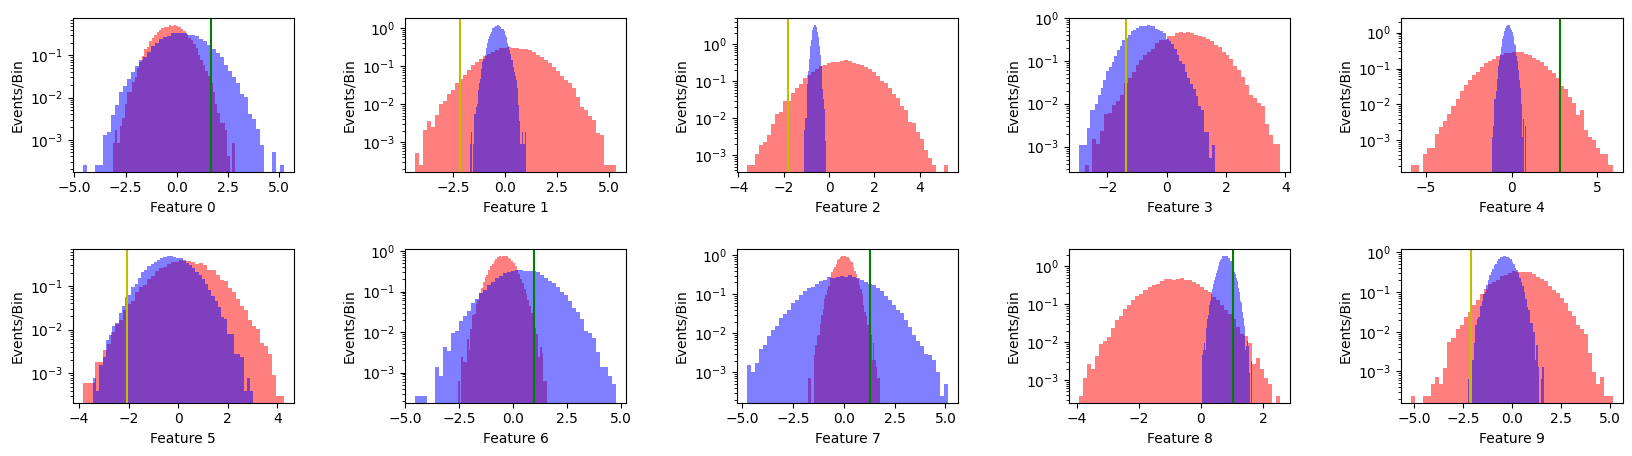

In [17]:
LCU.plotfeatures(net,x_signal,x_backgr,sc)

# SUSY DATA

In [6]:
x_signal_susy, y_signal_susy, x_backgr_susy, y_backgr_susy, branches_susy = LCU.load_SUSY_data()

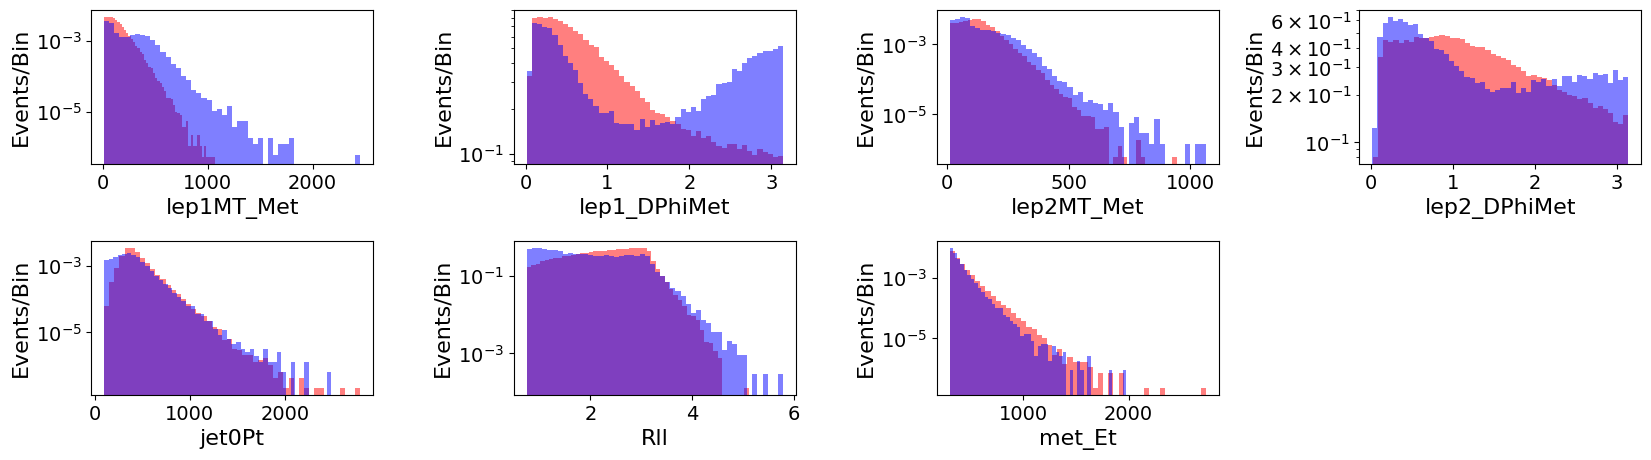

In [7]:
m = len(branches_susy)
plotting_features(x_signal_susy, x_backgr_susy, branches_susy, m)

In [8]:
x, y = concatenating(x_signal_susy, y_signal_susy, x_backgr_susy, y_backgr_susy)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [10]:
sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train)
x_test_scaled  = sc.transform(x_test)

In [11]:
x_train_tensor=torch.tensor(x_train_scaled,dtype=torch.float)
y_train_tensor=torch.tensor(y_train,dtype=torch.float)

x_test_tensor=torch.tensor(x_test_scaled,dtype=torch.float)
y_test_tensor=torch.tensor(y_test,dtype=torch.float)

In [12]:
gt=1.
lt=-1.
cuts_gt_lt = [lt, lt, lt, lt, gt, lt, lt]

In [13]:
targeteffics=[0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

# some hyperparameters
learning_rate=0.5
batch_size=int(len(y_train)/1.) # only one batch
epochs=25

# how we scale the inputs to the activation function.
# larger values improve the matching of the signal efficiency
# calculated in the loss function and the efficiency that we
# see when applying the cuts.
activation_input_scale_factor=15

# parameters for the loss functions
alpha    = 1e1   # scaling factor to tune how important hitting the target signal efficiency is
beta     = 1e-1  # scaling factor to tune how important background rejection is
gamma    = 1e-5  # scaling factor for how aggressively to push the cuts to zero
delta    = 1e-6  # scaling factor for how much to use BCE loss to optimize
epsilon  = 1e0   # how much to penalize deviations.  as the exponent goes down, this should go down too.

In [14]:
torch.manual_seed(123)

net = EfficiencyScanNetwork(m,targeteffics,cuts_gt_lt,activation_input_scale_factor) # will take m inputs, return m*n_eff outputs
torch.save(net.state_dict(), 'models/net_SUSY_learningbiases_effictarget_untrained.pth')

optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.1)

In [15]:
losses = []
losses_test = []

net.load_state_dict(torch.load('models/net_SUSY_learningbiases_effictarget_untrained.pth',weights_only=True))

xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=batch_size, shuffle=True)

debug=False

for epoch in range(epochs):
    net.train()
    start_time = time.time()
    for x_batch, y_batch in loader:
        y_pred = net(x_batch)
        optimizer.zero_grad()
        loss = effic_loss_fn(y_pred, y_batch, m, net, alpha, beta, gamma, delta, epsilon,debug=debug)
        loss.totalloss().backward()
        optimizer.step()
    losses.append(loss)
    net.eval() # configure the model for evaluation (testing)
    y_pred = net(x_test_tensor)
    test_loss = effic_loss_fn(y_pred, y_test_tensor, m, net, alpha, beta, gamma, delta, epsilon)        
    losses_test.append(test_loss)
    end_time=time.time()
    elapsed_time = end_time - start_time
    print(f"Completed epoch {epoch:2d} in {elapsed_time:4.1f}s, Train loss={loss.totalloss().data:4.1e}, Test loss={test_loss.totalloss().data:4.1e}")

torch.save(net.state_dict(), 'models/net_SUSY_learningbiases_effictarget_trained.pth')

Completed epoch  0 in  1.9s, Train loss=2.5e+01, Test loss=1.8e+01
Completed epoch  1 in  1.3s, Train loss=1.8e+01, Test loss=1.3e+01
Completed epoch  2 in  3.4s, Train loss=1.3e+01, Test loss=8.0e+00
Completed epoch  3 in  1.5s, Train loss=8.1e+00, Test loss=4.5e+00
Completed epoch  4 in  1.7s, Train loss=4.5e+00, Test loss=2.4e+00
Completed epoch  5 in  1.8s, Train loss=2.4e+00, Test loss=1.4e+00
Completed epoch  6 in  1.5s, Train loss=1.4e+00, Test loss=8.6e-01
Completed epoch  7 in  2.2s, Train loss=8.8e-01, Test loss=6.1e-01
Completed epoch  8 in  3.7s, Train loss=6.2e-01, Test loss=4.8e-01
Completed epoch  9 in  2.7s, Train loss=4.9e-01, Test loss=4.1e-01
Completed epoch 10 in  1.8s, Train loss=4.2e-01, Test loss=3.7e-01
Completed epoch 11 in  2.0s, Train loss=3.8e-01, Test loss=3.5e-01
Completed epoch 12 in  1.5s, Train loss=3.6e-01, Test loss=3.4e-01
Completed epoch 13 in  1.9s, Train loss=3.5e-01, Test loss=3.3e-01
Completed epoch 14 in  2.5s, Train loss=3.4e-01, Test loss=3.2

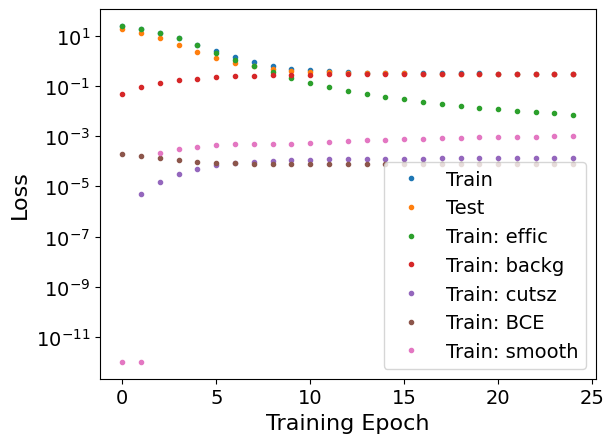

In [16]:
LCU.plotlosses(losses,losses_test)

In [17]:
for n in range(len(targeteffics)):
    print(f"Target efficiency: {targeteffics[n]*100}%")
    LCU.check_effic(x_test_tensor,y_test,net.nets[n],True)

    # check that after reloading the weights we still get the same performance after pretraining
    net.nets[n].eval() # configure the model for evaluation (testing)
    y_pred = net.nets[n](x_test_tensor)
    test_loss = loss_fn(y_pred, y_test_tensor, m, net.nets[n], targeteffics[n], alpha, beta, gamma, delta, True)
    print("------------")

Target efficiency: 20.0%
Signal     efficiency with net outputs: 20.5%
Background efficiency with net outputs: 17.33579%
Inspecting efficiency loss: alpha=10.0, target=0.200, subnet_effic=0.1990, subnet_backg=0.1696, efficloss=1.070e-05, backgloss=1.696e-02
------------
Target efficiency: 30.0%
Signal     efficiency with net outputs: 30.7%
Background efficiency with net outputs: 23.18105%
Inspecting efficiency loss: alpha=10.0, target=0.300, subnet_effic=0.2992, subnet_backg=0.2287, efficloss=6.332e-06, backgloss=2.287e-02
------------
Target efficiency: 40.0%
Signal     efficiency with net outputs: 40.4%
Background efficiency with net outputs: 28.78019%
Inspecting efficiency loss: alpha=10.0, target=0.400, subnet_effic=0.3987, subnet_backg=0.2839, efficloss=1.597e-05, backgloss=2.839e-02
------------
Target efficiency: 50.0%
Signal     efficiency with net outputs: 50.1%
Background efficiency with net outputs: 33.87171%
Inspecting efficiency loss: alpha=10.0, target=0.500, subnet_effic

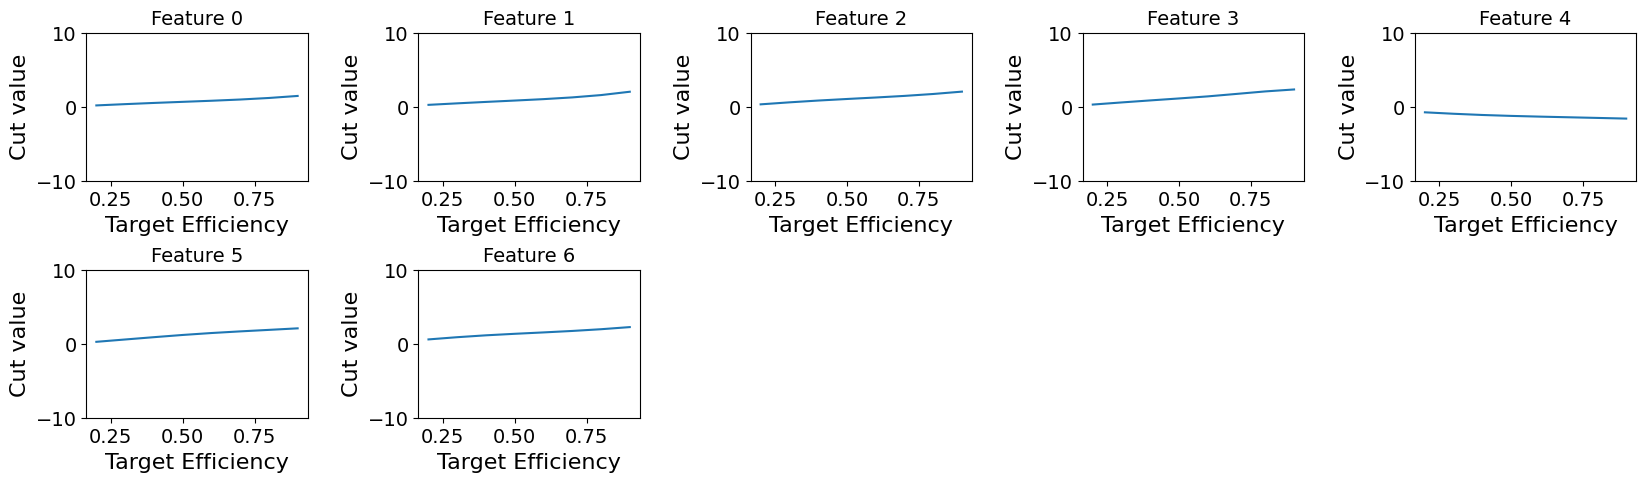

In [18]:
# Distributions of cuts
LCU.plotgenericcuts(net)

Target efficiency: 20.0%


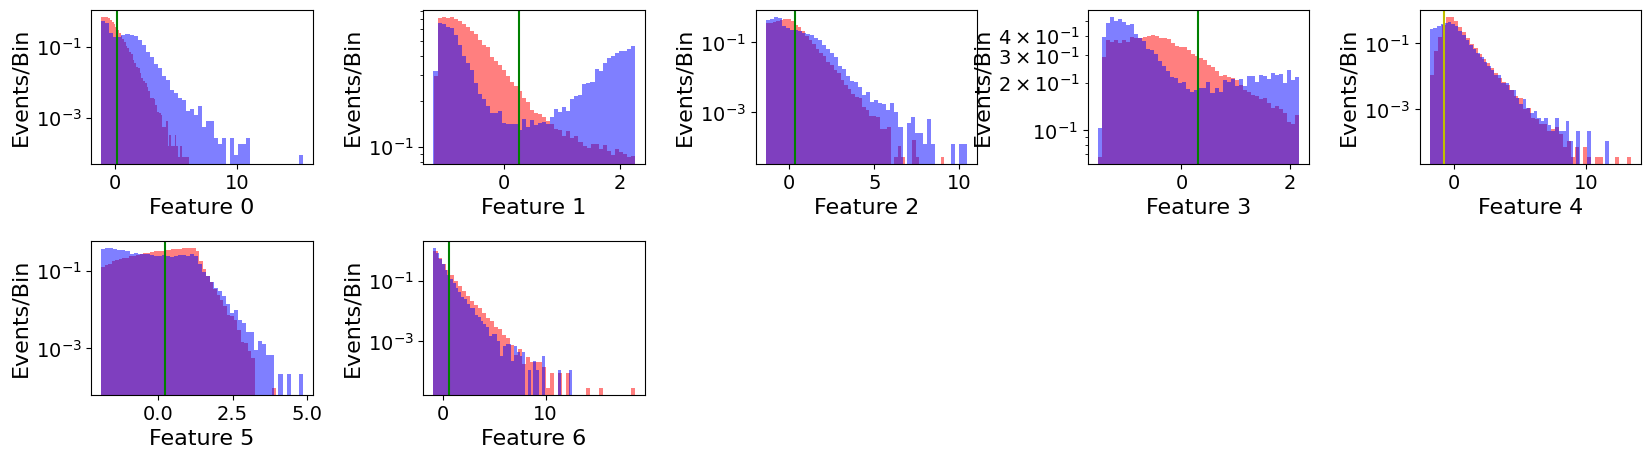

Target efficiency: 30.0%


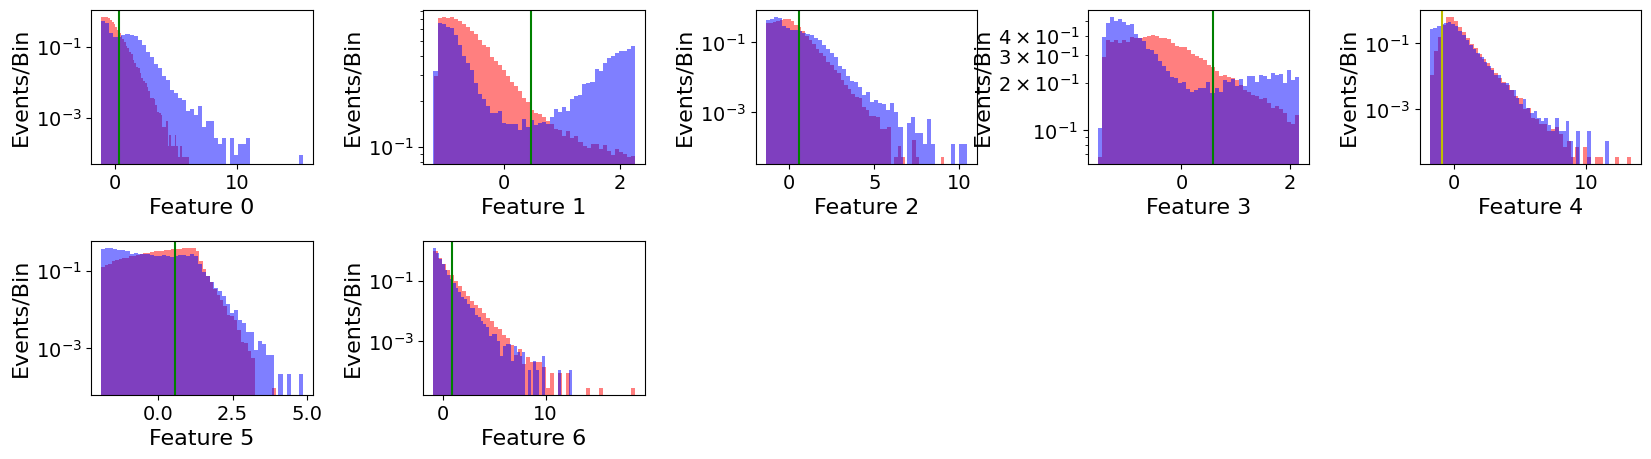

Target efficiency: 40.0%


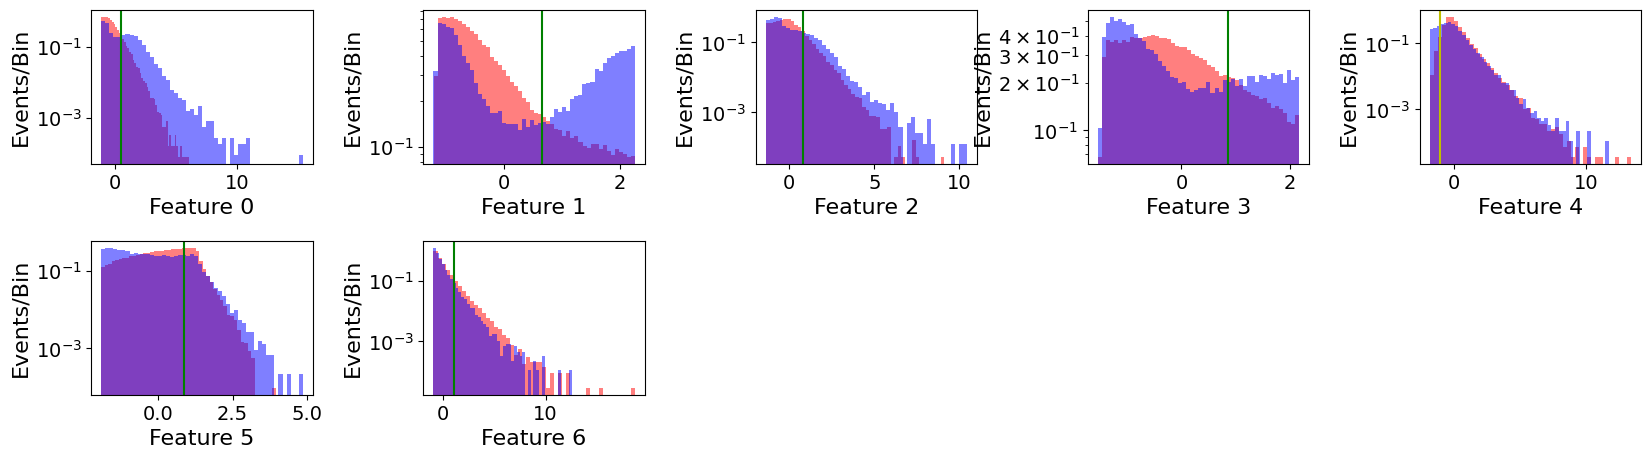

Target efficiency: 50.0%


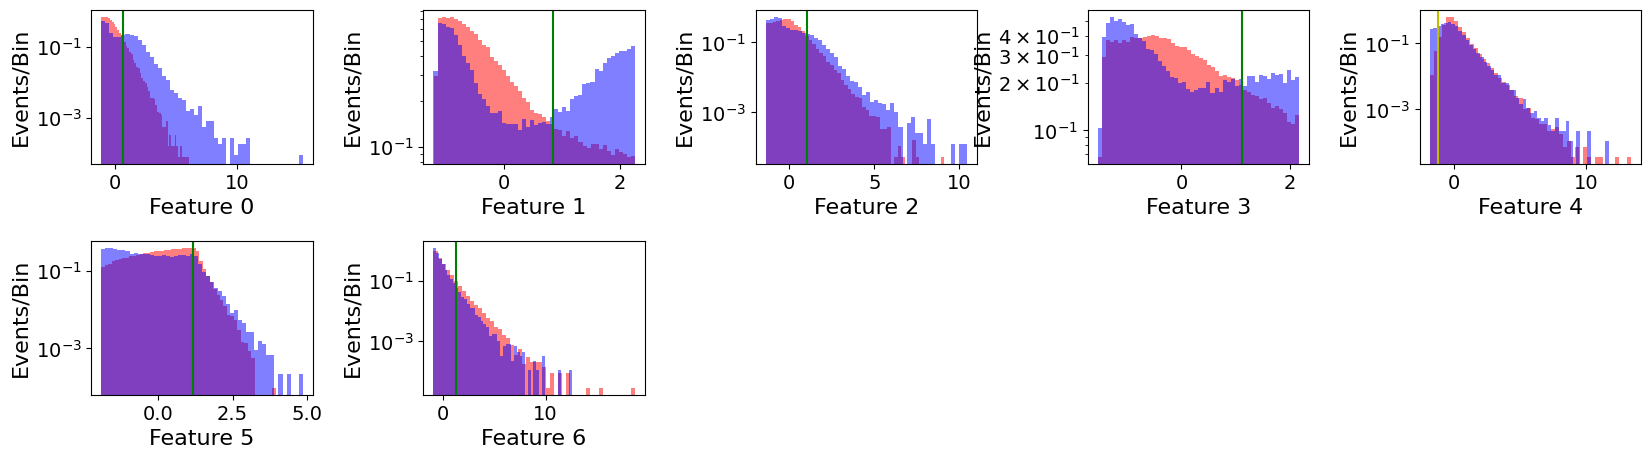

Target efficiency: 60.0%


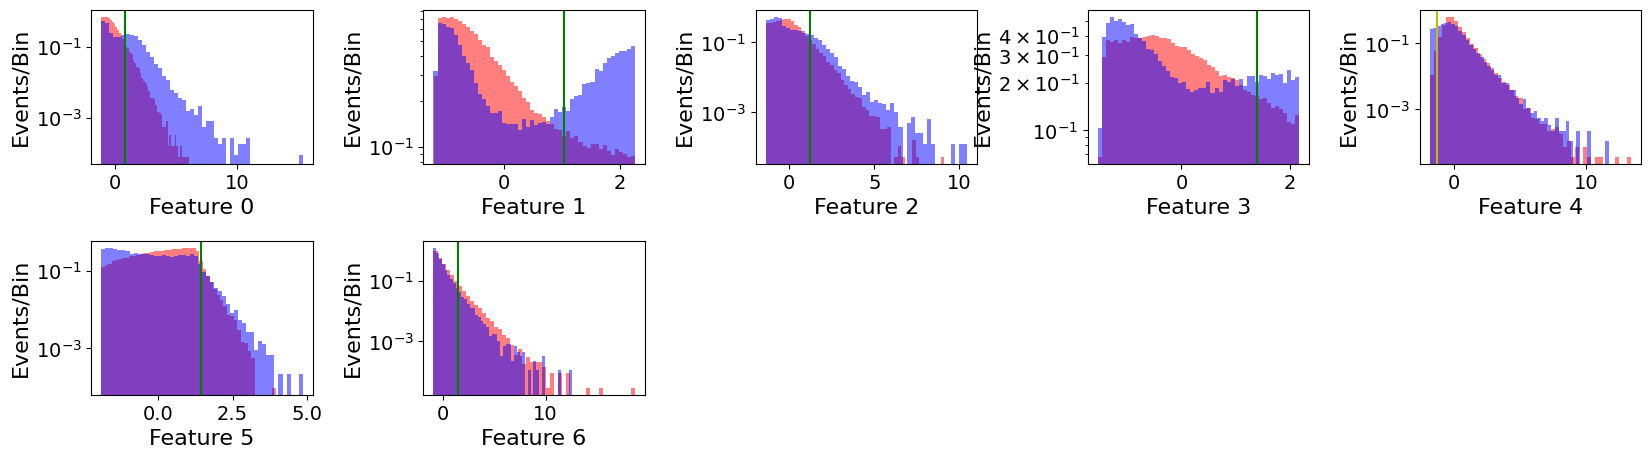

Target efficiency: 70.0%


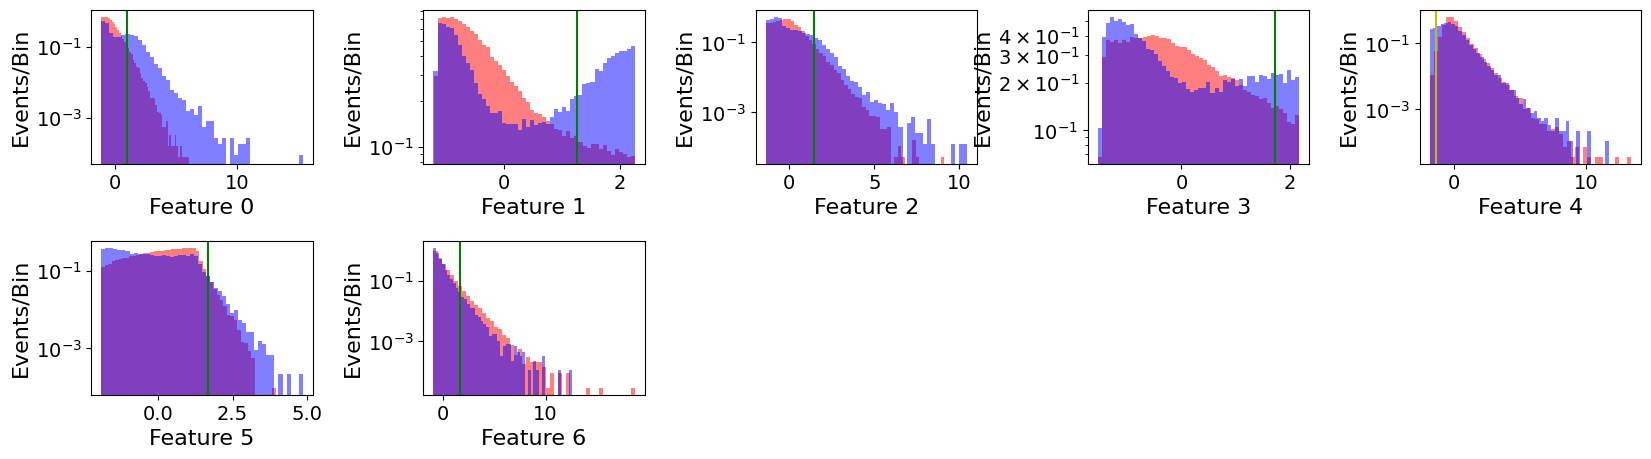

Target efficiency: 80.0%


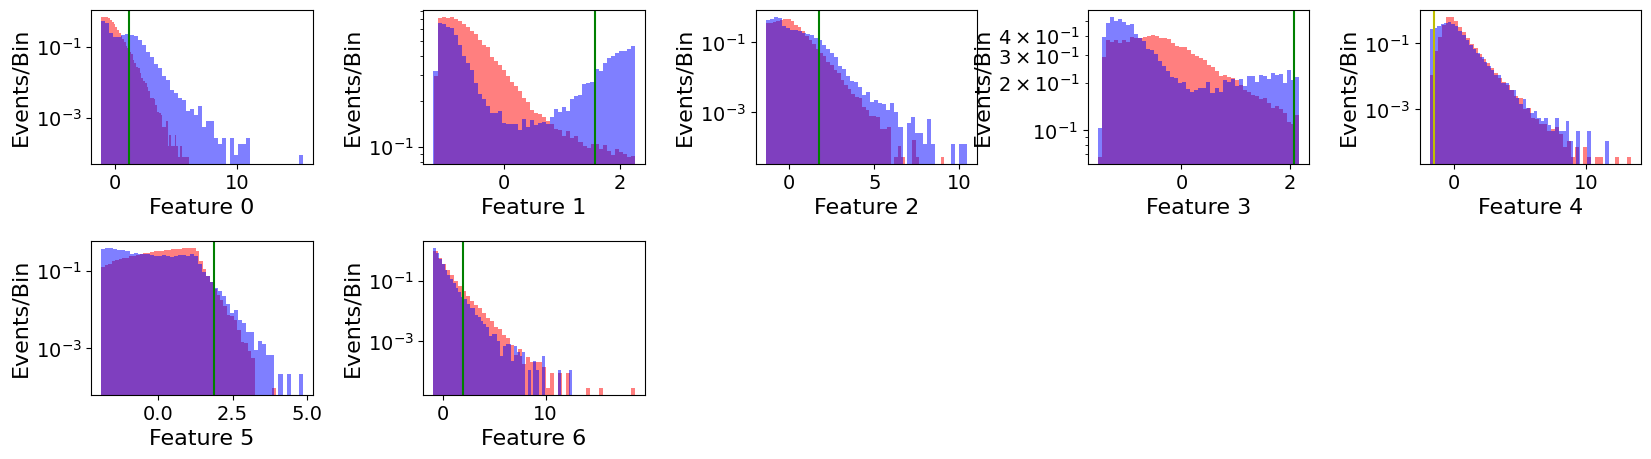

Target efficiency: 90.0%


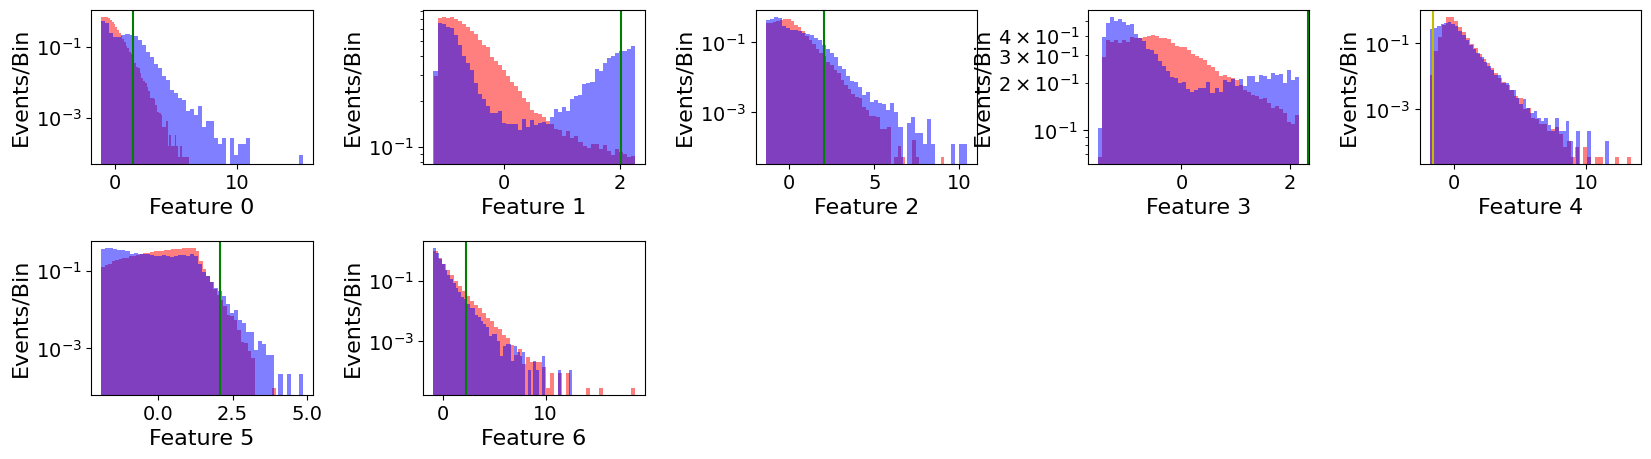

In [19]:
LCU.plotfeatures(net,x_signal_susy,x_backgr_susy,sc)